In [2]:
import dual_active_bridge_ti as tools

## Check computation of loss densities

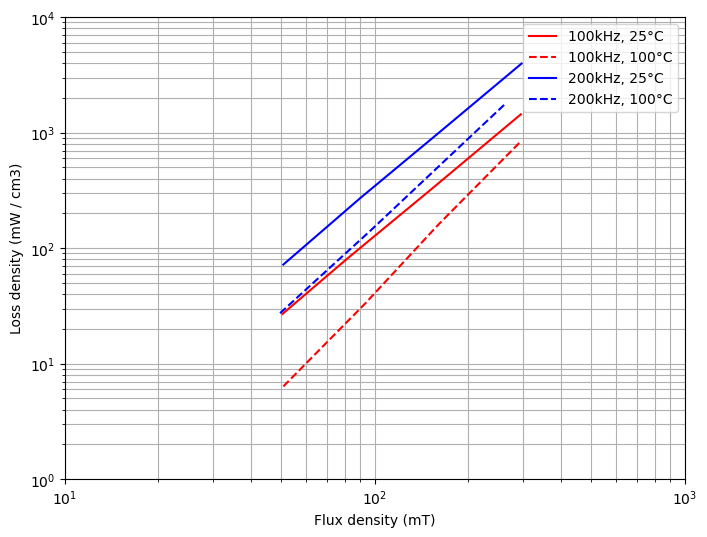

The interpolated loss density at:
 - B = 200 mT,
 - frequency = 100 kHz,
 - temperature = 100°C,
is 290 mW / cm3

The interpolated loss density at:
 - B = 0 mT,
 - frequency = 300 kHz,
 - temperature = 60°C,
is 0 mW / cm3


In [3]:
tools.plot_magnetic_loss_data()

flux_density = 200  # flux_density 200 mT
frequency = 100e3  # Frequency 150 kHz
temperature = 100  # Temperature 60°C
print(f"The interpolated loss density at:\n - B = {flux_density} mT,\n - frequency = {frequency/1e3:0.0f} kHz,\n - temperature = {temperature}°C,\nis {tools.compute_loss_density(flux_density, frequency, temperature):0.0f} mW / cm3\n")

flux_density = 0  # flux_density 100 mT
frequency = 300e3  # Frequency 150 kHz
temperature = 60  # Temperature 60°C
print(f"The interpolated loss density at:\n - B = {flux_density} mT,\n - frequency = {frequency/1e3:0.0f} kHz,\n - temperature = {temperature}°C,\nis {tools.compute_loss_density(flux_density, frequency, temperature):0.0f} mW / cm3")

## Compute core volume and equivalent magnetizing inductor of transformer

In [4]:
# Compute transformer volume based on 2 E-core E64/18/50
core_volume = 2 * tools.compute_single_ecore_volume(64, 18, 50)
print(f'Core volume: {core_volume / 1e3 :0.1f} cm3')

# Compute equivalent magnetizing inductor
Ac = 0.000516                               # core section m²
Le = 0.112                                  # magnetic path length (m)
ur = [2400, 2200]                           # relative permeability µi and µe
Npri = 24
Lm = tools.compute_equivalent_Lm(Npri, Le, Ac, ur)
print(f'Magnetizing inductor: {Lm[0] * 1e3:.2f} mH for µe = µi = {ur[0]}')
print(f'Magnetizing inductor: {Lm[1] * 1e3:.2f} mH for µe = {ur[1]}')


Core volume: 90.0 cm3
Magnetizing inductor: 8.00 mH for µe = µi = 2400
Magnetizing inductor: 7.34 mH for µe = 2200


## Simulate DAB converter model in Simba

In [5]:
# Parameters
Vin = 800
fsw = 100e3
phase_shift = 23
Rlk = 23e-3
Rpri = 43e-3
Rsec = 16e-3

# Simulate
res = tools.run_simulation(Vin, fsw, phase_shift, Lm[0], Rlk, Rpri, Rsec)


## Powerswitch Losses & Junction temperatures

Total Powerswitch Loss: 126.39 W


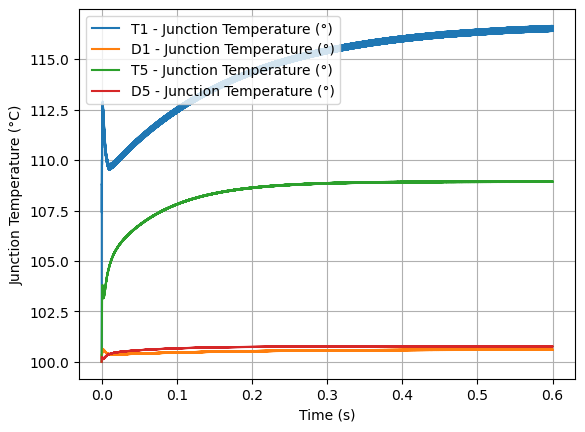

In [6]:
powerswitch_loss = tools.compute_powerswitch_losses(res)

## DC Copper Losses

In [7]:
time, iPri, iSec, iLm = tools.steadystate_signal(1 / fsw, res['iPri'], res['iSec'], res['iLm'])
dcLoss_inductor, dcLoss_pri, dcLoss_sec = tools.compute_dc_copper_losses(time, iPri, iSec, Rpri, Rsec, Rlk)

Primary RMS current: 14.01 A
Secondary RMS current: 22.51 A
Inductor DC loss: 4.52 W
Primary DC loss: 8.44 W
Secondary DC loss: 8.11 W


## Core Magnetic Losses

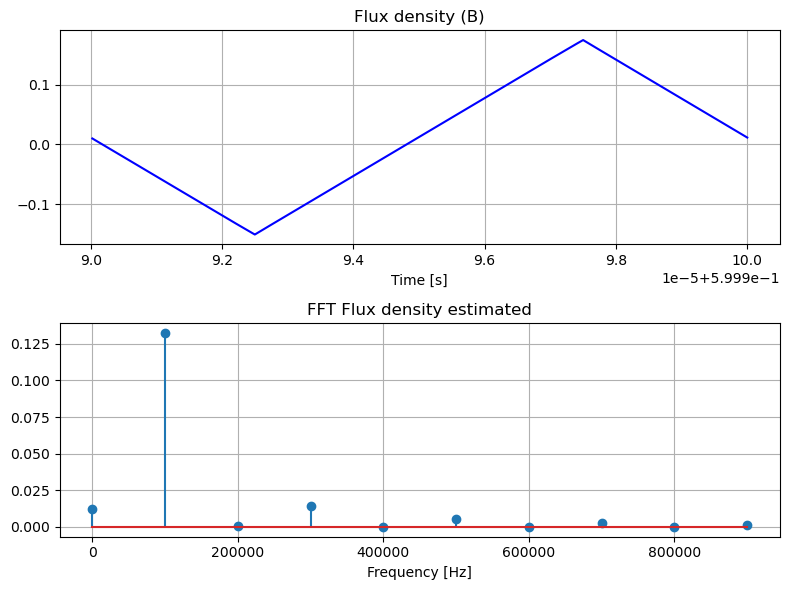

In [8]:
flux_density, freqs, fft_flux_densities = tools.compute_flux_density(time, iLm, Lm[0], Npri, Ac, fsw)

In [9]:
temperature = 100
core_Loss1 = tools.compute_magnetic_losses_fftmethod(freqs, fft_flux_densities, temperature, core_volume)
core_Loss2 = tools.compute_magnetic_losses_maxmethod(flux_density, fft_flux_densities, temperature, Ac, fsw, core_volume)


--- Core Loss computation with FFT of flux density method ---
Loss density at 100°C, 0 kHz, 12 mT is 0.00 mW / cm3
Loss density at 100°C, 100 kHz, 133 mT is 92.05 mW / cm3
Loss density at 100°C, 300 kHz, 14 mT is 1.34 mW / cm3
Loss density at 100°C, 500 kHz, 5 mT is 0.12 mW / cm3
Loss density at 100°C, 700 kHz, 3 mT is 0.02 mW / cm3
Loss density at 100°C, 900 kHz, 2 mT is 0.01 mW / cm3
Total Loss density at 100°C:  93.5 mW / cm3
Total Core Loss (FFT) at 100°C:  8.4 W

--- Core Loss computation with max flux density method ---
Estimated maximum flux density: 163 mT
Theoretical maximum flux density: 161 mT (for comparison)
Total Core Loss (max flux density) at 100°C :  15.1 W


## Estimation of efficiency and Loss coefficient

In [10]:
tools.compute_efficiency(core_Loss2, dcLoss_inductor, dcLoss_pri, dcLoss_sec, powerswitch_loss)

Efficiency: 98.40%
Loss coefficient: 1.60%
